In [1]:
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from layers import Flatten,FullyConnected,Linear,Tanh
from losses import cross_entropy, cross_entropy_derivative
from train import fit, predict
from scipy import signal
from model import CNN


# 08 & 07

We have implemented "ConvolutionalNet" Convolution layer which can take work on cahnnel_count >= 1 

In [2]:
class ConvolutionalNet():
    
    def __init__(self, input_shape, kernel, channel_count):
        """
        :param input_shape: input shape: (channel_count, height, width)
        :param kernel: kernel shape: (channel_count, input_channel_count, height, width)
        :param channel_count: number of output channels
        :return None
    
        """
        input_channel_count, input_height, input_width = input_shape
        self.channel_count = channel_count
        self.input_shape = input_shape
        self.input_channel_count = input_channel_count
        
        #find shape of kernels and output
        self.output_shape = (channel_count, input_height - kernel + 1, input_width - kernel + 1)
        self.kernels_shape = (channel_count, input_channel_count, kernel, kernel)

        #initialize kernels and biases with random values
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward_pass(self, input):
        """
        :param input: input shape: (channel_count, height, width)
        :return: output shape: (channel_count, height - kernel + 1, width - kernel + 1)

        """
        self.input = input
        self.output = np.copy(self.biases)
        #convolve input with kernels and add biases to the output

        for i in range(self.channel_count):
            for j in range(self.input_channel_count):
                #correlate2d will find the convolution of the input and kernel
                self.output[i] += signal.correlate2d(
                    self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward_pass(self, output_gradient, learning_rate):
        """
        :param output_gradient: output gradient shape: (channel_count, height - kernel + 1, width - kernel + 1)
        :return: input gradient shape: (channel_count, height, width)

        """
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.channel_count):
            for j in range(self.input_channel_count):
                kernels_gradient[i, j] = signal.correlate2d(
                    self.input[j], output_gradient[i], "valid")
                    #convolve2d willdo the backward pass of the convolution
                input_gradient[j] += signal.convolve2d(
                    output_gradient[i], self.kernels[i, j], "full")
                    
        #update kernels and biases
        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

# 09

## preprocess the data

In [3]:
def preprocess_data(x, y, limit):
    """
    :param x: input data
    :param y: output data
    :param limit: number of samples to be used
    :return: x and y data with shape (limit, 28, 28) and (limit, 10) respectively
    
    """
    x = x[:limit]
    y = y[:limit]
    #convert rgb to grayscale
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    #convert labels to one hot encoding
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), 10, 1)
    return x, y


## Load the Data

In [4]:
data = mnist.load_data()

In [5]:
# load MNIST from server
(x_fit, y_fit), (x_test, y_test) = mnist.load_data()
x_fit, y_fit = preprocess_data(x_fit, y_fit, 1000)
x_test, y_test = preprocess_data(x_test, y_test, 200)

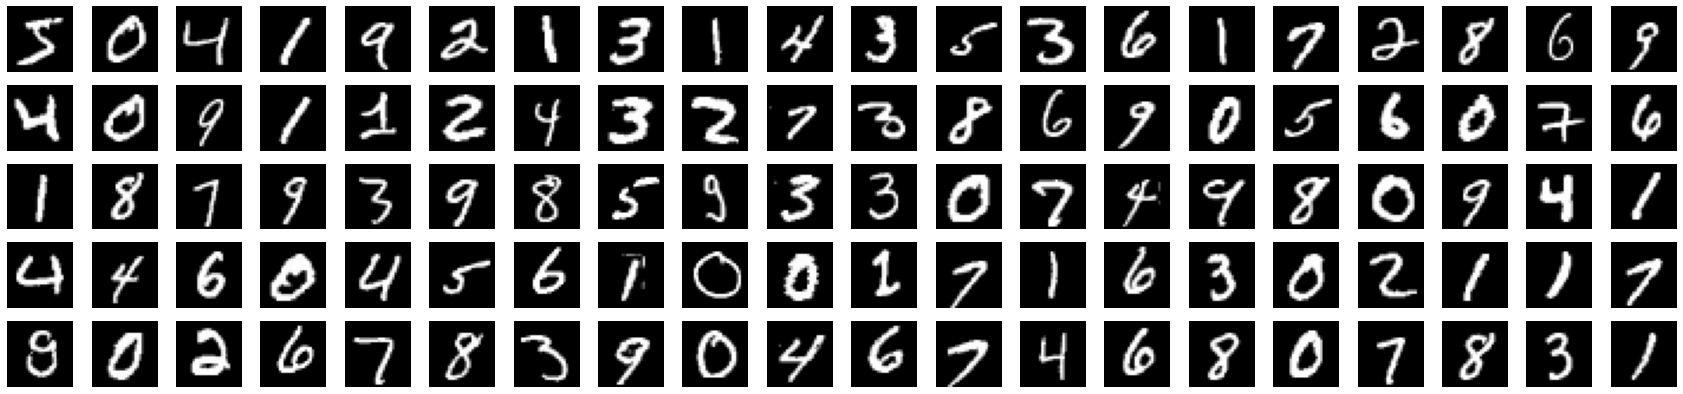

In [6]:
#show first 20 images present in x_fit


fig = plt.figure(figsize=(30, 7))

for i in range(100):
    fig.add_subplot(5, 20, i+1)
    plt.imshow(data[0][0][i], 'gray')
    plt.axis('off')

plt.show()
    

In [7]:
#print the size of the fiting and test data
print(x_fit.shape)
print(y_fit.shape)

(1000, 1, 28, 28)
(1000, 10, 1)


## Model Formation and fit the Network

In [10]:

network = CNN()
#adding layers to the network
#Layer 1 Convolution layer with 16 output channels + flatten + tanh activation , kernel size is 5*5
network.add(ConvolutionalNet((1, 28, 28), 5, 16))
network.add(Tanh())
    network.add(Flatten((16, 24, 24), (16 * 24 * 24, 1)))
    #apply fully connected layer with 50 output neurons + linear activation
    FullyConnected(16* 24 * 24, 50),
    Linear(),
    #finally apply 10 output neurons with linear activation
    FullyConnected(50, 10),
    Linear()

CNN = [
    #Layer 1 Convolution layer with 16 output channels + flatten + tanh activation , kernel size is 5*5
    ConvolutionalNet((1, 28, 28), 5, 16),
    Tanh(),
    Flatten((16, 24, 24), (16 * 24 * 24, 1)),
    #apply fully connected layer with 50 output neurons + linear activation
    FullyConnected(16* 24 * 24, 50),
    Linear(),
    #finally apply 10 output neurons with linear activation
    FullyConnected(50, 10),
    Linear()
]

In [11]:
# fit
fit(
    CNN,
    #add the loss function
    cross_entropy,
    cross_entropy_derivative,
    x_fit,
    y_fit,
    epochs=30,
    learning_rate=0.1
)

epoch - 1, ----- error for this epoch is=0.43599906173205694
epoch - 2, ----- error for this epoch is=0.28248573681792716
epoch - 3, ----- error for this epoch is=0.24620993559049903
epoch - 4, ----- error for this epoch is=0.21440518489238092
epoch - 5, ----- error for this epoch is=0.19451348528259993
epoch - 6, ----- error for this epoch is=0.18437224211864048
epoch - 7, ----- error for this epoch is=0.16933662378038272
epoch - 8, ----- error for this epoch is=0.1551635636654053
epoch - 9, ----- error for this epoch is=0.14761071803493286
epoch - 10, ----- error for this epoch is=0.13964137629986964
epoch - 11, ----- error for this epoch is=0.1315309806261866
epoch - 12, ----- error for this epoch is=0.12556361006605768
epoch - 13, ----- error for this epoch is=0.121232905071708
epoch - 14, ----- error for this epoch is=0.12205230704087001
epoch - 15, ----- error for this epoch is=0.11903283127214226
epoch - 16, ----- error for this epoch is=0.11221174973370812
epoch - 17, ----- err

## Test the Data

In [12]:
# test
test=[]
pred=[]
for x, y in zip(x_test, y_test):
    output = predict(CNN, x)
    #apply softmax to the output and get the predicted class
    test.append(np.argmax(output))
    pred.append(np.argmax(y))
#find the accuracy
print('accuracy:',np.sum(np.array(test)==np.array(pred))*100/len(test))

accuracy: 80.0


## References

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html


https://deepnotes.io/softmax-crossentropy


https://medium.com/data-science-in-your-pocket/creating-cnn-from-scratch-using-tensorflow-mnist-dataset-35ce91b787f2


https://github.com/TheIndependentCode/Neural-Network